Data collected using Google Places JavaScript API
* folder [poi-collection](/tree/poi-collection)
* it was possible to search by rectangle areas
* limit: 60 places per query
  * solution: 1 query per grid cell _(a very small cell)_

In [1]:
import os
import json
from shapely.geometry.point import Point
import geopandas as gpd
from bikescience import sp_grid
import folium
import matplotlib.pyplot as plt

from bikescience import sp_grid

js_folder = '../../../poi-collection/templates/'
data_folder = '../../../data/sao-paulo/training-sets/processing/'
#sampa_city = sp_grid.create(n=40, west_offset=.1, east_offset=.01, north_offset=.01, south_offset=.1)
sampa_city = sp_grid.create(n=40, west_offset=-.1, east_offset=.01, north_offset=.01, south_offset=-.1)

Input for POI collection 

* A JavaScript array used by the web application

In [2]:
cells_to_collect = sampa_city.geodataframe()
print(len(cells_to_collect), type(cells_to_collect))
cells_to_collect.head()

1600 <class 'geopandas.geodataframe.GeoDataFrame'>


i  j                                           geometry
0  0  0  POLYGON ((-46.73605000000001 -23.6489, -46.736...
1  0  1  POLYGON ((-46.73330000000001 -23.6489, -46.733...
2  0  2  POLYGON ((-46.73055000000001 -23.6489, -46.730...
3  0  3  POLYGON ((-46.7278 -23.6489, -46.7278 -23.6461...
4  0  4  POLYGON ((-46.72505 -23.6489, -46.72505 -23.64...

In [4]:
rects = []
for rect in cells_to_collect.geometry:
    xy = rect.exterior.coords.xy
    points = []
    for r in range(4):
        points.append([xy[1][r], xy[0][r]])
    rects.append(json.dumps(points) + ',')
with open(js_folder + 'grid-bounds-sp.js', 'w') as f:
    f.write('var grid_cells = [\n')
    for r in rects: f.write(r + '\n')
    f.write(']')

The raw data file
* Can have repeated points
* 1 JSON element per line

In [5]:
raw_file = data_folder + 'data_file'
file = open(raw_file)
places = []
for line in file:
    places.append(json.loads(line))
file.close()
print(len(places), 'POI records')
places[0]

76867 POI records


{'geometry': {'location': {'lat': -23.5408662, 'lng': -46.6308459},
  'viewport': {'east': -46.6294562697085,
   'north': -23.5395199697085,
   'south': -23.5422179302915,
   'west': -46.63215423029146}},
 'html_attributions': [],
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
 'id': '7288c97e6b18d1e38f856f02983e660350e16e9e',
 'name': 'Hotel Macuco',
 'photos': [{'height': 1836,
   'html_attributions': ['<a href="https://maps.google.com/maps/contrib/115421396483743245921/photos">Roberto Santana</a>'],
   'width': 3264}],
 'place_id': 'ChIJR7laVVBQzpQRtsad8B7FDzs',
 'plus_code': {'compound_code': 'F959+MM São Paulo, SP, Brasil',
  'global_code': '588MF959+MM'},
 'rating': 3.8,
 'reference': 'ChIJR7laVVBQzpQRtsad8B7FDzs',
 'scope': 'GOOGLE',
 'types': ['lodging', 'point_of_interest', 'establishment'],
 'user_ratings_total': 113,
 'vicinity': 'Rua Barão de Duprat, 369 - Santo Amaro'}

Place types

In [6]:
place_types = []
for p in places:
    for t in p['types']:
        if t == 'point_of_interest' or t == 'establishment': continue
        if not t in place_types: place_types.append(t)
place_types

['lodging',
 'shopping_mall',
 'store',
 'home_goods_store',
 'food',
 'supermarket',
 'grocery_or_supermarket',
 'clothing_store',
 'real_estate_agency',
 'meal_takeaway',
 'restaurant',
 'jewelry_store',
 'lawyer',
 'health',
 'insurance_agency',
 'hardware_store',
 'department_store',
 'shoe_store',
 'finance',
 'accounting',
 'furniture_store',
 'hair_care',
 'atm',
 'parking',
 'electronics_store',
 'movie_rental',
 'bank',
 'police',
 'school',
 'courthouse',
 'car_repair',
 'travel_agency',
 'church',
 'place_of_worship',
 'bar',
 'night_club',
 'general_contractor',
 'laundry',
 'car_dealer',
 'bicycle_store',
 'local_government_office',
 'spa',
 'car_rental',
 'movie_theater',
 'cafe',
 'convenience_store',
 'gas_station',
 'dentist',
 'doctor',
 'locksmith',
 'pharmacy',
 'painter',
 'beauty_salon',
 'bakery',
 'hospital',
 'book_store',
 'meal_delivery',
 'electrician',
 'university',
 'subway_station',
 'transit_station',
 'gym',
 'plumber',
 'liquor_store',
 'moving_compan

Converting to GeoDataFrame

In [7]:
places_data = {
    'id': [],
    'geometry': [],
}

for t in place_types:
    places_data[t] = []

for p in places:
    if p['id'] in places_data['id']: continue
    places_data['id'].append(p['id'])
    lat = p['geometry']['location']['lat']
    lng = p['geometry']['location']['lng']
    places_data['geometry'].append(Point(lng, lat))
    for t in place_types:
        places_data[t].append(1 if t in p['types'] else 0)
    
places_geodf = gpd.GeoDataFrame(places_data, crs={'init': 'epsg:4326'})
print(len(places_geodf), 'places')
places_geodf.head()

66996 places


accounting  airport  amusement_park  aquarium  art_gallery  atm  bakery  \
0           0        0               0         0            0    0       0   
1           0        0               0         0            0    0       0   
2           0        0               0         0            0    0       0   
3           0        0               0         0            0    0       0   
4           0        0               0         0            0    0       0   

   bank  bar  beauty_salon  ...  store  subway_station  supermarket  \
0     0    0             0  ...      0               0            0   
1     0    0             0  ...      0               0            0   
2     0    0             0  ...      1               0            0   
3     0    0             0  ...      1               0            0   
4     0    0             0  ...      1               0            0   

   synagogue  taxi_stand  train_station  transit_station  travel_agency  \
0          0           0              0                0              0   
1          0           0              0                0              0   
2          0           0              0                0              0   
3          0           0              0                0              0   
4          0           0              0                0              0   

   university  veterinary_care  
0           0                0  
1           0                0  
2           0                0  
3           0                0  
4           0                0  

[5 rows x 98 columns]

Checking for POI duplication

In [6]:
no_dup = places_geodf.drop(columns=['geometry']).drop_duplicates()
len(no_dup), len(places_geodf.id.unique())

(66996, 66996)

Save data

In [7]:
with open(data_folder + 'places.geojson', 'w') as f:
    f.write(places_geodf.to_json())

In [ ]:
# previously saved file
places_geodf = gpd.read_file(data_folder + 'places.geojson')
place_types = places_geodf.columns.tolist()
place_types.remove('geometry')
print(len(places_geodf), 'places')
places_geodf.head()

In [9]:
places_geodf.geometry.head()

0           POINT (-46.6308459 -23.5408662)
1     POINT (-46.63095699999997 -23.541391)
2            POINT (-46.6296711 -23.540525)
3    POINT (-46.63083059999997 -23.5408968)
4    POINT (-46.63017969999999 -23.5398004)
Name: geometry, dtype: object

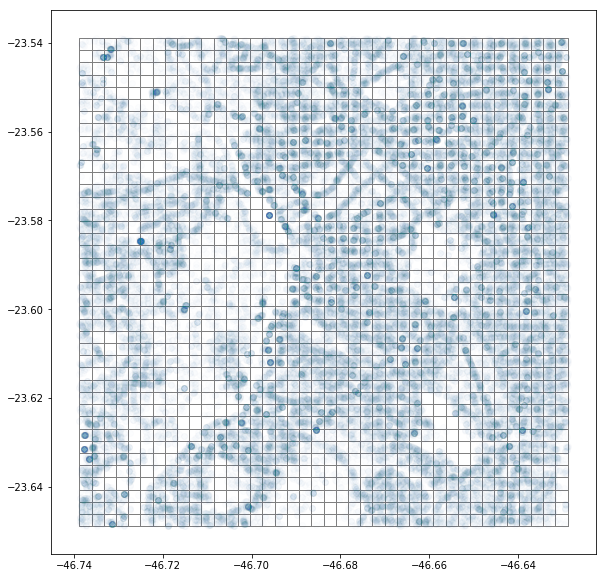

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
sampa_city.geodataframe().plot(ax=ax, edgecolor='gray', facecolor='none')
places_geodf.plot(ax=ax, alpha=.01)
plt.show()

Do all grid cells have POIs?

In [11]:
sjoin = gpd.sjoin(sampa_city.geodataframe(), places_geodf, op='contains', how='left')
countings = sjoin.groupby(['i', 'j'], as_index=False).agg({'id': 'count'})
countings.rename(columns={'id': 'countings'}, inplace=True)
countings.countings.value_counts().head()

60    416
59    131
61     78
58     63
62     39
Name: countings, dtype: int64